# Fine-tuning a model for music classification

Modelimizi eğitmek için, müzik türü sınıflandırması için 1.000 şarkıdan oluşan popüler bir veri kümesi olan GTZAN veri kümesini kullanacağız. Her şarkı, diskodan metale kadar uzanan 10 müzik türünden birinden 30 saniyelik bir kliptir.

In [1]:
from datasets import load_dataset

dataset = load_dataset("marsyas/gtzan", "all", trust_remote_code=True)
dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 999
    })
})

In [2]:
split_params = {
    "seed": 42,
    "shuffle": True,
    "test_size": 0.1,
    "stratify_by_column": "genre",
}

dataset = dataset['train'].train_test_split(**split_params)
dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 899
    })
    test: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 100
    })
})

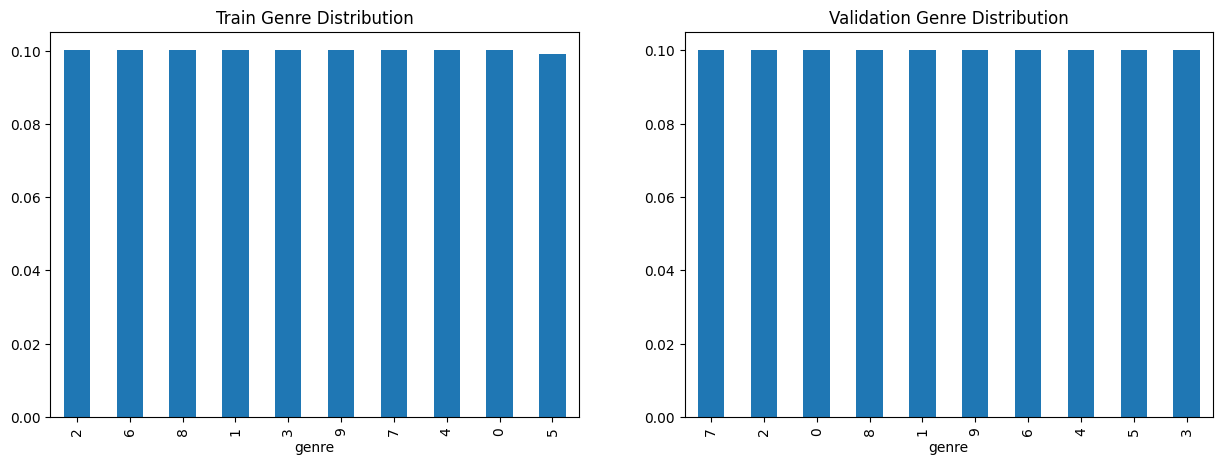

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.DataFrame(dataset["train"])
val_df = pd.DataFrame(dataset["test"])

def calculate_genre_distribution(df):
    genre_counts = df['genre'].value_counts()
    total_samples = len(df)
    genre_proportions = genre_counts / total_samples
    return genre_counts, genre_proportions

train_counts, train_proportions = calculate_genre_distribution(train_df)
val_counts, val_proportions = calculate_genre_distribution(val_df)


fig, axes = plt.subplots(1, 2, figsize=(15, 5))
train_proportions.plot(kind='bar', ax=axes[0], title='Train Genre Distribution')
val_proportions.plot(kind='bar', ax=axes[1], title='Validation Genre Distribution')

plt.show()

In [4]:
dataset["train"][0]

{'file': '/root/.cache/huggingface/datasets/downloads/extracted/5022b0984afa7334ff9a3c60566280b08b5179d4ac96a628052bada7d8940244/genres/country/country.00020.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/5022b0984afa7334ff9a3c60566280b08b5179d4ac96a628052bada7d8940244/genres/country/country.00020.wav',
  'array': array([0.09390259, 0.09164429, 0.09054565, ..., 0.01123047, 0.01434326,
         0.01702881]),
  'sampling_rate': 22050},
 'genre': 2}

Ünite 1'de gördüğümüz gibi, ses dosyaları 1 boyutlu NumPy dizileri olarak temsil edilir, burada dizinin değeri o zaman adımındaki genliği temsil eder. Bu şarkılar için örnekleme hızı 22.050 Hz'dir, yani saniyede örneklenen 22.050 genlik değeri vardır. Farklı bir örnekleme oranına sahip önceden eğitilmiş bir model kullanırken bunu aklımızda tutmamız ve eşleştiklerinden emin olmak için örnekleme oranlarını kendimiz dönüştürmemiz gerekecek. Ayrıca türün bir tamsayı veya sınıf etiketi olarak temsil edildiğini de görebiliriz, bu da modelin tahminlerini yapacağı formattır. Bu tamsayıları insan tarafından okunabilir adlara eşlemek için tür özelliğinin int2str() yöntemini kullanalım:

In [5]:
id2label_fn = dataset["train"].features["genre"].int2str
id2label_fn(dataset["train"][0]["genre"])

'country'

## Picking a pretrained model for audio classification

Başlamak için, ses sınıflandırması için uygun bir ön eğitimli model seçelim. Bu alanda, ön eğitim genellikle LibriSpeech ve Voxpopuli gibi veri kümeleri kullanılarak büyük miktarda etiketsiz ses verisi üzerinde gerçekleştirilir. Bu modelleri Hugging Face Hub'ında bulmanın en iyi yolu, önceki bölümde açıklandığı gibi "Ses Sınıflandırması" filtresini kullanmaktır. Wav2Vec2 ve HuBERT gibi modeller çok popüler olsa da, biz DistilHuBERT adlı bir model kullanacağız. Bu, HuBERT modelinin çok daha küçük (veya damıtılmış) bir versiyonudur, yaklaşık %73 daha hızlı eğitir, ancak performansın çoğunu korur.

## Preprocessing the data

NLP'deki tokenizasyona benzer şekilde, ses ve konuşma modelleri girdinin modelin işleyebileceği bir formatta kodlanmasını gerektirir. Transformers'da, sesten giriş formatına dönüşüm, modelin özellik çıkarıcısı tarafından gerçekleştirilir. Tokenizer'lara benzer şekilde Transformers, belirli bir model için doğru özellik çıkarıcıyı otomatik olarak seçebilen kullanışlı bir AutoFeatureExtractor sınıfı sağlar. Ses dosyalarımızı nasıl işleyebileceğimizi görmek için, önceden eğitilmiş kontrol noktasından DistilHuBERT için özellik çıkarıcıyı örnekleyerek başlayalım:

In [6]:
from transformers import AutoFeatureExtractor

model_id = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id, do_normalize=True
)

preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Modelin ve veri kümesinin örnekleme hızı farklı olduğundan, ses dosyasını özellik çıkarıcıya aktarmadan önce 16.000 Hz'e yeniden örneklememiz gerekecektir. Bunu, ilk olarak modelin örnekleme hızını özellik çıkarıcıdan alarak yapabiliriz:

In [7]:
sampling_rate = feature_extractor.sampling_rate
sampling_rate

16000

In [8]:
from datasets import Audio

dataset = dataset.cast_column("audio", Audio(sampling_rate=sampling_rate))
dataset["train"][0]

{'file': '/root/.cache/huggingface/datasets/downloads/extracted/5022b0984afa7334ff9a3c60566280b08b5179d4ac96a628052bada7d8940244/genres/country/country.00020.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/5022b0984afa7334ff9a3c60566280b08b5179d4ac96a628052bada7d8940244/genres/country/country.00020.wav',
  'array': array([0.07599887, 0.09681445, 0.08715075, ..., 0.00928226, 0.01690463,
         0.        ]),
  'sampling_rate': 16000},
 'genre': 2}

Harika! Örnekleme hızının 16kHz'e düşürüldüğünü görebiliyoruz. Dizi değerleri de farklıdır, çünkü artık daha önce sahip olduğumuz her 1,5 için yaklaşık bir genlik değerine sahibiz.

Wav2Vec2 ve HuBERT benzeri modellerin tanımlayıcı bir özelliği, konuşma sinyalinin ham dalga biçimine karşılık gelen bir float dizisini girdi olarak kabul etmeleridir. Bu, ham ses dalga biçimini spektrogram biçimine önceden işlediğimiz Whisper gibi diğer modellerin aksine.

Ses verilerinin 1 boyutlu bir dizi olarak temsil edildiğinden bahsetmiştik, bu nedenle model tarafından okunmak için zaten doğru formatta (ayrık zaman adımlarında bir dizi sürekli girdi). Peki, özellik çıkarıcı tam olarak ne yapar?

Ses verisi doğru formatta, ancak alabileceği değerler konusunda herhangi bir kısıtlama getirmedik. Modelimizin en iyi şekilde çalışması için tüm girdileri aynı dinamik aralıkta tutmak istiyoruz. Bu, örneklerimiz için benzer bir aktivasyon ve gradyan aralığı elde etmemizi sağlayacak ve eğitim sırasında kararlılığa ve yakınsamaya yardımcı olacaktır.

Bunu yapmak için, her bir örneği sıfır ortalama ve birim varyansa yeniden ölçeklendirerek ses verilerimizi normalleştiririz; bu işleme özellik ölçeklendirme adı verilir. Özellik çıkarıcımızın gerçekleştirdiği tam olarak bu özellik normalleştirmesidir!

İlk ses örneğimize uygulayarak özellik çıkarıcıya çalışırken bir göz atabiliriz. İlk olarak, ham ses verilerimizin ortalamasını ve varyansını hesaplayalım:

Pekala! Özellik çıkarıcımız iki diziden oluşan bir sözlük döndürür: input_values ve attention_mask. input_values, HuBERT modeline ileteceğimiz önceden işlenmiş ses girdileridir. attention_mask, bir grup ses girdisini bir kerede işlediğimizde kullanılır - modele farklı uzunluklardaki girdileri nerede doldurduğumuzu söylemek için kullanılır.

Ortalama değerin artık sıfıra çok daha yakın olduğunu ve varyansın bire çok yakın olduğunu görebiliriz! Bu, ses örneklerimizi HuBERT modeline beslemeden önce tam olarak istediğimiz formdur.

Harika, artık yeniden örneklenmiş ses dosyalarımızı nasıl işleyeceğimizi biliyoruz, yapılacak son şey veri kümesindeki tüm örneklere uygulayabileceğimiz bir işlev tanımlamak. Ses kliplerinin 30 saniye uzunluğunda olmasını beklediğimizden, özellik çıkarıcının max_length ve truncation argümanlarını aşağıdaki gibi kullanarak daha uzun klipleri de keseceğiz:

In [9]:
max_duration = 30.0


def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
    )
    return inputs

In [10]:
dataset_encoded = dataset.map(
    preprocess_function,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size=100,
    num_proc=1,
)
dataset_encoded

Map:   0%|          | 0/899 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['genre', 'input_values'],
        num_rows: 899
    })
    test: Dataset({
        features: ['genre', 'input_values'],
        num_rows: 100
    })
})

Eğitimi basitleştirmek için ses ve dosya sütunlarını veri kümesinden kaldırdık. input_values sütunu kodlanmış ses dosyalarını, attention_mask ses girişini nereye doldurduğumuzu gösteren 0/1 değerlerinden oluşan ikili bir maskeyi ve genre sütunu ilgili etiketleri (veya hedefleri) içerir. Eğiticinin sınıf etiketlerini işlemesini sağlamak için, tür sütununu etiket olarak yeniden adlandırmamız gerekir:

In [11]:
dataset_encoded = dataset_encoded.rename_column("genre", "label")
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values'],
        num_rows: 899
    })
    test: Dataset({
        features: ['label', 'input_values'],
        num_rows: 100
    })
})

In [12]:
id2label = {
    str(i): id2label_fn(i)
    for i in range(len(dataset_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}
label2id, id2label

({'blues': '0',
  'classical': '1',
  'country': '2',
  'disco': '3',
  'hiphop': '4',
  'jazz': '5',
  'metal': '6',
  'pop': '7',
  'reggae': '8',
  'rock': '9'},
 {'0': 'blues',
  '1': 'classical',
  '2': 'country',
  '3': 'disco',
  '4': 'hiphop',
  '5': 'jazz',
  '6': 'metal',
  '7': 'pop',
  '8': 'reggae',
  '9': 'rock'})

## Fine-tuning the model

In [13]:
from transformers import AutoModelForAudioClassification

model = AutoModelForAudioClassification.from_pretrained(
    model_id,
    num_labels=len(id2label),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from huggingface_hub import notebook_login

notebook_login()

In [16]:
from transformers import TrainingArguments

model_name = model_id.split("/")[-1]
batch_size = 16
gradient_accumulation_steps = 1
num_train_epochs = 20
early_stopping_patience = 4

training_args = TrainingArguments(
    f"{model_name}-finetuned-gtzan",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=True,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
!pip install -q evaluate

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [18]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    acc = accuracy.compute(predictions=predictions, references=labels)
    prec = precision.compute(predictions=predictions, references=labels, average='weighted')
    rec = recall.compute(predictions=predictions, references=labels, average='weighted')
    f1_score = f1.compute(predictions=predictions, references=labels, average='weighted')
    
    return {
        "accuracy": acc["accuracy"],
        "precision": prec["precision"],
        "recall": rec["recall"],
        "f1": f1_score["f1"]
    }

In [19]:
from transformers import Trainer, EarlyStoppingCallback

trainer = Trainer(
    model,
    training_args,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)
    ]
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.855200,0.596219,0.830000,0.869318,0.830000,0.820744
2,0.448000,0.516703,0.850000,0.873590,0.850000,0.853415
3,0.163400,0.543298,0.860000,0.877951,0.860000,0.857022
4,0.167300,0.474325,0.880000,0.883644,0.880000,0.876950
5,0.006500,0.495593,0.910000,0.921212,0.910000,0.906025
6,0.027900,0.563496,0.890000,0.897078,0.890000,0.887912
7,0.104000,0.679889,0.860000,0.883247,0.860000,0.856440
8,0.001000,0.492661,0.910000,0.924560,0.910000,0.910943
9,0.000200,0.389863,0.920000,0.924545,0.920000,0.918705
10,0.000200,0.371530,0.930000,0.938636,0.930000,0.931108


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generatio

TrainOutput(global_step=798, training_loss=0.18262119808004945, metrics={'train_runtime': 3192.2291, 'train_samples_per_second': 5.632, 'train_steps_per_second': 0.357, 'total_flos': 8.531757156060365e+17, 'train_loss': 0.18262119808004945, 'epoch': 14.0})

In [20]:
trainer.evaluate()

{'eval_loss': 0.3715299963951111,
 'eval_accuracy': 0.93,
 'eval_precision': 0.9386363636363637,
 'eval_recall': 0.93,
 'eval_f1': 0.9311080732133363,
 'eval_runtime': 13.8224,
 'eval_samples_per_second': 7.235,
 'eval_steps_per_second': 0.506,
 'epoch': 14.0}

In [21]:
kwargs = {
    "dataset_tags": "marsyas/gtzan",
    "dataset": "GTZAN",
    "model_name": f"{model_name}-finetuned-gtzan",
    "finetuned_from": model_id,
    "tasks": "audio-classification",
}

trainer.push_to_hub(**kwargs)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


events.out.tfevents.1723199741.f4f28b392a64.35.1:   0%|          | 0.00/560 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Leotrim/ast-finetuned-audioset-10-10-0.4593-finetuned-gtzan/commit/6694ace1a996dfb729be55cd292f3a6deef7553e', commit_message='End of training', commit_description='', oid='6694ace1a996dfb729be55cd292f3a6deef7553e', pr_url=None, pr_revision=None, pr_num=None)